In [1]:
%load_ext autoreload
%autoreload 2

# Analysing the Variability in the Energy Confinement Time Based on Classification. 

In [2]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import get_ECT_regression, HUEOrder, get_pi_matrix, clean_numerical_data, MyCounter

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rc('axes', axisbelow=True)

plt.rcParams["mathtext.fontset"] = "cm"

import warnings

# Turn off Matplotlib warnings
warnings.filterwarnings("ignore")

import matplotlib.font_manager as fm
from PIL import Image
#import imageio
import imageio.v2 as imageio
from matplotlib.lines import Line2D
from PIL import Image
from matplotlib.gridspec import GridSpec

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import matplotlib.ticker as ticker
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns

import plotly.express as px
import plotly.subplots as plsp
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from collections import Counter

pd.set_option('display.max_columns', None)
path = "../data/"
fig_path = "../../../LATEX/Latex Images/"
coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']

plt.rc('font',family = 'serif')

In [3]:
# Obtained from Optimization

min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")
min_subset_ids_joe  = pd.read_csv(path+"deviation_id.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# Removing Spherical TOKAMAKS
#DB5 = DB5[~DB5["TOK"].isin(['START','MAST','NSTX'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = "Decreasing"

DB5.insert(loc=2,column="label_9998",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = "Decreasing"

DB5.insert(loc=2,column="label_joe",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_joe.id)].index), "label_joe"] = "Decreasing"

DB5.insert(loc=2,column="Spherical",value=["No Spherical"]*len(DB5))
DB5.loc[(DB5[DB5.TOK.isin(['START','MAST','NSTX'])].index), "Spherical"] = "Spherical"

DB5.insert(0, 'intercept', np.ones(len(DB5)))


print(
    "  Subset that decrease alpha-R to 0.6357\n--------\n" +
    f"{ round( (len(min_subset_ids_6357)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_6357)/len(DB5))*100 ,2)  }% did not affect alpha_R" +
    "\n\n\n  Subset that decrease alpha-R to 0.9998\n--------\n" +
    f"{ round( (len(min_subset_ids_9998)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_9998)/len(DB5))*100 ,2)  }% did not affect alpha_R"
    "\n\n\n  Subset given by Joseph Hall           \n--------\n" +
    f"{ round( (len(min_subset_ids_joe)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_joe)/len(DB5))*100 ,2)  }% did not affect alpha_R"
)

DB5 = tokamakTK.clean_categorical_data(DB5)

  Subset that decrease alpha-R to 0.6357
--------
23.45% affected alpha_R
76.55% did not affect alpha_R


  Subset that decrease alpha-R to 0.9998
--------
9.88% affected alpha_R
90.12% did not affect alpha_R


  Subset given by Joseph Hall           
--------
18.46% affected alpha_R
81.54% did not affect alpha_R


In [4]:
markers = ["o", "v", "^", "<", ">", "P", 9, ".", 
           "8", "s", "p", 11, "*", "h", "H", "X", "D", "d"]
tok_markers = dict(zip(DB5["TOK"].unique(), markers))

In [5]:
def get_HUEORDER(DB5):
    DB5 = tokamakTK.clean_categorical_data(DB5)
    # Needed for Improved Visualization: 2D and 3D Plots
    HUE_ORDER, PX_ORDER = tokamakTK.get_colors_per_category(DB5)
    hue_order = HUEOrder(HUE_ORDER)

    # ---------------------------------------------------

    # SPECIAL PARAMETERS
    colors_ = sns.color_palette('tab20', 20)
    HUE_ORDER["Spherical"] = dict(zip(sorted(DB5["Spherical"].unique()), colors_[:len(DB5["Spherical"].unique())]))
    HUE_ORDER["label_joe"] = dict(zip(sorted(DB5["label_joe"].unique()), colors_[:len(DB5["label_joe"].unique())]))
    HUE_ORDER["TOK"]["START"] = (0.8235, 0.5055, 0.4412)
    
    return HUE_ORDER, PX_ORDER

HUE_ORDER, PX_ORDER = get_HUEORDER(DB5)

In [6]:
data1 = DB5[DB5.label_6357.isin(["Decreasing"])].reset_index(drop=True)
data2 = DB5[DB5.label_6357.isin(["Unaffected"])].reset_index(drop=True)
# Removing DB2 observations in unaffected dataset for a fair comparison
data2 = data2[~data2.id.isin(DB2.id.values)].reset_index(drop=True)

data = [data1,data2]

In [7]:
# ----- DB2 Dataset -------------------------------------
DB2prms = get_ECT_regression(DB2).params.to_dict()
DB2prms['const'] = np.exp(DB2prms['const'])

# ----- DB5 Dataset -------------------------------------
DB5prms = get_ECT_regression(DB5).params.to_dict()
DB5prms['const'] = np.exp(DB5prms['const'])

# ----- Big Dataset -------------------------------------
# -- Decreasing
DDsprms = get_ECT_regression(DB5[DB5.id.isin(min_subset_ids_6357.id.values) | 
                                 DB5.id.isin(DB2.id.values)
                                ]).params.to_dict()
DDsprms['const'] = np.exp(DDsprms['const'])
# -- Unaffected
UDsprms = get_ECT_regression(DB5[~DB5.id.isin(min_subset_ids_6357.id.values)]).params.to_dict()
UDsprms['const'] = np.exp(UDsprms['const'])

In [8]:
def predict_TauE(Mprms, df):
    """
    Model parameters (Mprms)
    Device parameters (df)
    """
    tau = (Mprms['const'] * (df["IP"]**Mprms["IP"]) * (df["BT"]**Mprms["BT"]) *
          (df["NEL"]**Mprms["NEL"]) * (df["PLTH"]**Mprms["PLTH"]) * (df["RGEO"]**Mprms["RGEO"]) *
          (df["KAREA"]**Mprms["KAREA"]) * (df["EPS"]**Mprms["EPS"]) * (df["MEFF"]**Mprms["MEFF"])
          )
    return tau

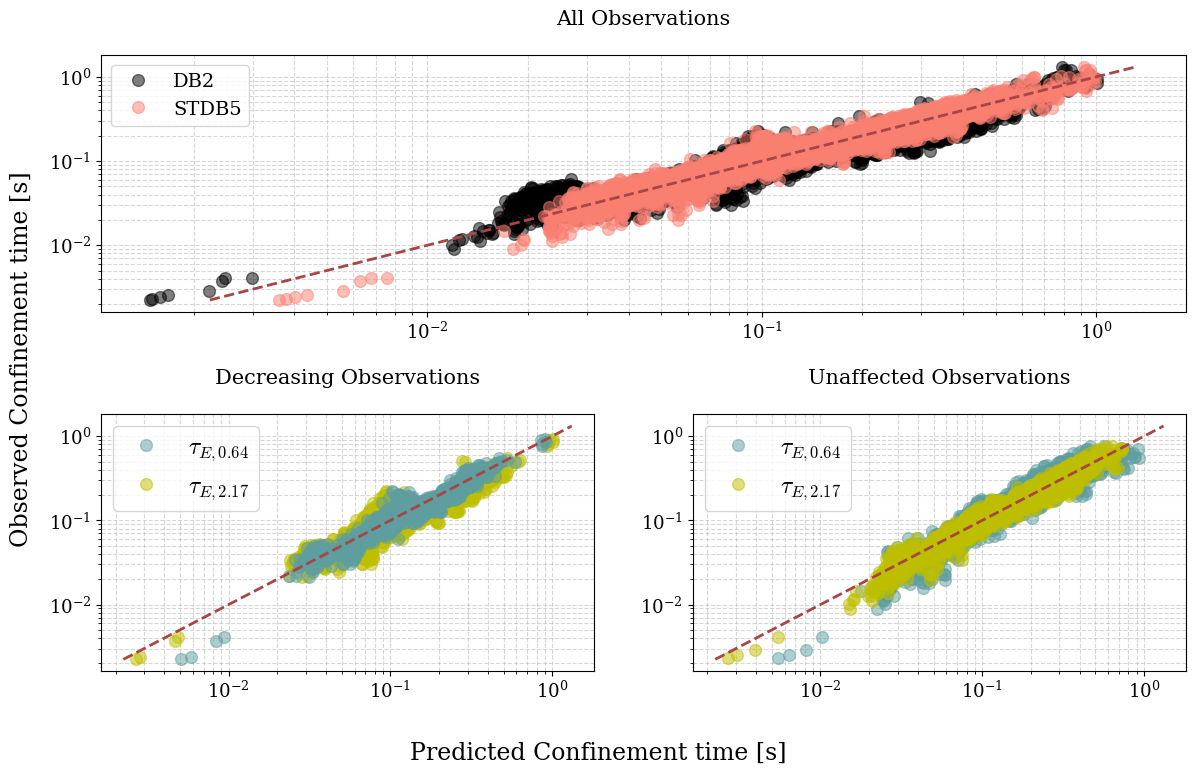

In [17]:

# Create a figure and a GridSpec layout
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 2, figure=fig)

# Create the top plot (LONG)
ax_long = fig.add_subplot(gs[0, :])
ax_long.loglog(predict_TauE(DB2prms, DB5[coeffs].apply(abs)), DB5["TAUTH"], 
               '.', color="k", label="DB2", markersize=17, alpha=0.5)
ax_long.loglog(predict_TauE(DB5prms, DB5[coeffs].apply(abs)), DB5["TAUTH"], 
               '.', color="salmon", label="STDB5", markersize=17, alpha=0.5)
# Add the other lines and settings for the LONG plot

# Create the bottom left plot (SMALL 1)
ax_small1 = fig.add_subplot(gs[1, 0])
ax_small1.loglog(predict_TauE(UDsprms, data1[coeffs].apply(abs)), data1["TAUTH"], 
                 '.', color="y", label="$\\tau_{E, 2.17}$", markersize=17, alpha=0.5)
ax_small1.loglog(predict_TauE(DDsprms, data1[coeffs].apply(abs)), data1["TAUTH"], 
                 '.', color="cadetblue", label="$\\tau_{E,0.64}$", markersize=17, alpha=0.5)
# Add the other lines and settings for the first small plot

# Create the bottom right plot (SMALL 2)
ax_small2 = fig.add_subplot(gs[1, 1])
ax_small2.loglog(predict_TauE(DDsprms, data2[coeffs].apply(abs)), data2["TAUTH"], 
                 '.', color="cadetblue", label="$\\tau_{E,0.64}$", markersize=17, alpha=0.5)
ax_small2.loglog(predict_TauE(UDsprms, data2[coeffs].apply(abs)), data2["TAUTH"], 
                 '.', color="y", label="$\\tau_{E, 2.17}$", markersize=17, alpha=0.5)
# Add the other lines and settings for the second small plot

ax_long.grid(True, which='both', linestyle='dashed', alpha=0.5)
ax_small1.grid(True, which='both', linestyle='dashed', alpha=0.5)
ax_small2.grid(True, which='both', linestyle='dashed', alpha=0.5)
ax_long.tick_params(axis='both', which='major', labelsize=13)
ax_small1.tick_params(axis='both', which='major', labelsize=13)
ax_small2.tick_params(axis='both', which='major', labelsize=13)

fig.text(0.06, 0.5, "Observed Confinement time [s]", va='center', rotation='vertical', fontsize=17)
fig.text(0.48, 0, "Predicted Confinement time [s]", ha='center', fontsize=17);

ax_long.set_title("All Observations\n", fontsize=15)
ax_small1.set_title("Decreasing Observations\n", fontsize=15)
ax_small2.set_title("Unaffected Observations\n", fontsize=15)


ax_long.plot([min(DB5["TAUTH"]), max(DB5["TAUTH"])], 
         [min(DB5["TAUTH"]), max(DB5["TAUTH"])], 
         color="#A84547", linestyle='--', linewidth=2)
ax_small1.plot([min(DB5["TAUTH"]), max(DB5["TAUTH"])], 
         [min(DB5["TAUTH"]), max(DB5["TAUTH"])], 
         color="#A84547", linestyle='--', linewidth=2)
ax_small2.plot([min(DB5["TAUTH"]), max(DB5["TAUTH"])], 
         [min(DB5["TAUTH"]), max(DB5["TAUTH"])], 
         color="#A84547", linestyle='--', linewidth=2)

ax_long.legend(fontsize=14)
# Swap the order of the legend labels in the first plot
handles1, labels1 = ax_small1.get_legend_handles_labels()
handles1 = [handles1[1], handles1[0]]
labels1 = [labels1[1], labels1[0]]
ax_small1.legend(handles1,labels1,fontsize=17)
ax_small2.legend(fontsize=17)

# Adjust spacing between subplots
gs.update(hspace=0.4)

# Display the final figure
#plt.savefig(fig_path+"comparative_variability_TAUTH.pdf", format="pdf", dpi=800, bbox_inches='tight')
plt.show()